In [1]:
using HarmonicBalance, DifferentialEquations
import HarmonicBalance.TimeEvolution: ParameterSweep, ODEProblem

# Harmonic equations for the parametric oscillator

In [2]:
@variables γ,λ,F,θ,η,α, ω0, ω,t,T, ψ, x(t)

natural_equation =  d(d(x,t),t) + γ*d(x,t) + ω0^2*(1-λ*cos(2*ω*t+ψ))*x + α * x^3 +η *d(x,t) * x^2
forces =  F*cos(ω*t+θ)
dEOM = DifferentialEquation(natural_equation + forces, x)
add_harmonic!(dEOM, x, ω)
@time averagedEOM = get_harmonic_equations(dEOM, slow_time=T, fast_time=t)

 85.942914 seconds (131.44 M allocations: 7.475 GiB, 2.68% gc time, 99.34% compilation time)


# single sweep

In [3]:
fixed = ParameterList(ω0 => 1.0,γ => 1E-2, λ => 5E-2, F => 1E-3,  α => 1.,  η=>0.3, θ => 0, ψ => 0)
sweep = ParameterSweep(ω=>(0.95,0.98), (0, 2E4)) # linearly interpolate between two values at two times
prob=ODEProblem(averagedEOM, fixed, sweep=sweep, x0=[0.0001;0.0001], timespan=(0, 4E4))

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 40000.0)
u0: 2-element Vector{Float64}:
 0.0001
 0.0001

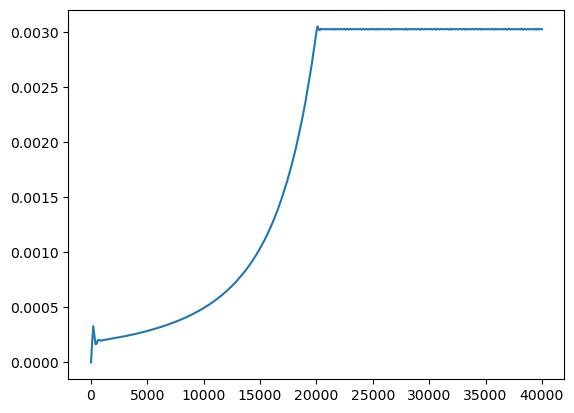

 32.532741 seconds (72.94 M allocations: 3.476 GiB, 3.42% gc time, 86.87% compilation time)


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/hrochan/.julia/packages/PyCall/3fwVL/src/numpy.jl:67


In [4]:
@time time_soln = solve(prob,saveat=100);
HarmonicBalance.plot(time_soln.t, getindex.(time_soln.u,1).^2 .+ getindex.(time_soln.u,2).^2);

# simultaneous sweep of multiple parameters

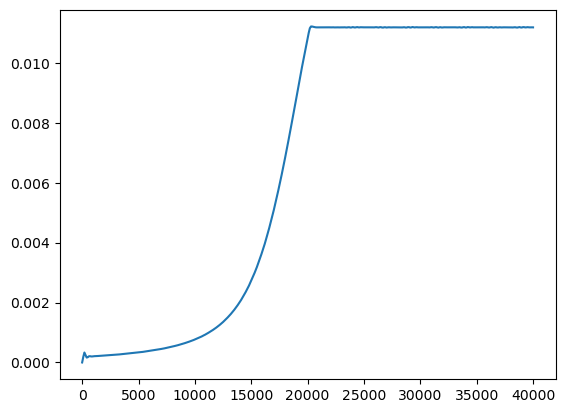

  3.136777 seconds (16.93 M allocations: 574.988 MiB, 5.45% gc time, 4.37% compilation time)


In [5]:
fixed_parameters = ParameterList(ω0 => 1.0,γ => 1E-2,  F => 1E-3,  α => 1.,  η=>0.3, θ => 0, ψ => 0)

# interpolate both parameters
sw_params = [ω=>[0.95;1.0],λ => [5E-2;1E-2]]
sweep=ParameterSweep(sw_params, (0, 2E4))

prob=ODEProblem(averagedEOM, fixed_parameters, sweep=sweep; x0=[0.0001;0.0001], timespan=(0,4E4))

@time time_soln = solve(prob,saveat=100);
HarmonicBalance.plot(time_soln.t, getindex.(time_soln.u,1).^2 .+ getindex.(time_soln.u,2).^2);

# series of sweeps

In [6]:
# combine two sweeps
sweep1 = ParameterSweep(ω => [0.95, 1.0], (0, 2E4))
sweep2 = ParameterSweep(λ => [0.05, 0.01], (2E4, 4E4))
sweep = sweep1 + sweep2

fixed_parameters = ParameterList(ω0 => 1.0,γ => 1E-2,  F => 1E-3,  α => 1.,  η=>0.3, θ => 0, ψ => 0)

prob=ODEProblem(averagedEOM, fixed_parameters, sweep=sweep; x0=[0.0001;0.0001], timespan=(0, 4E4));

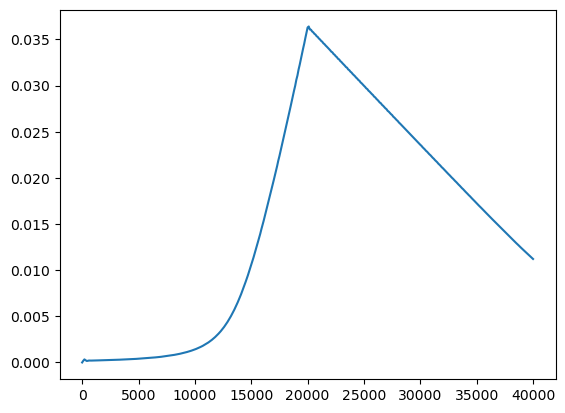

  4.023840 seconds (20.66 M allocations: 699.031 MiB, 4.22% gc time, 0.33% compilation time)


In [7]:
@time time_soln = solve(prob,saveat=100);
HarmonicBalance.plot(time_soln.t, getindex.(time_soln.u,1).^2 .+ getindex.(time_soln.u,2).^2);

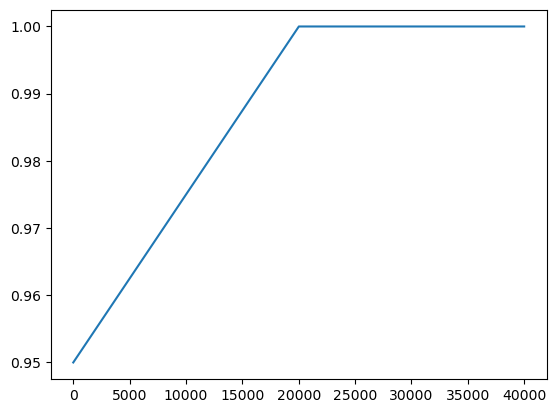

In [8]:
# check out our swept function
times = 0:4E4
HarmonicBalance.plot(times, sweep[ω].(times));

# Define custom sweep functions

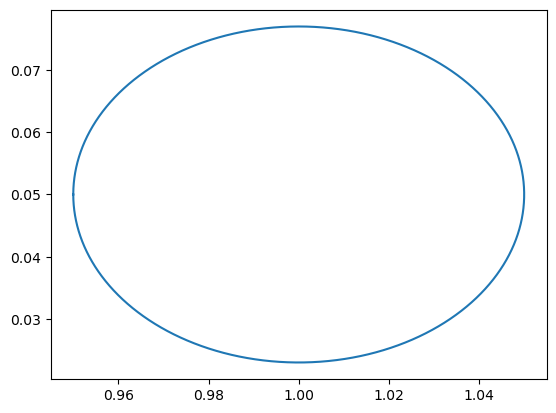

In [9]:
times = 0:2E4
ωfunc(t)=1-0.05*cos(2*pi*t/times[end])
λfunc(t)=0.05-0.027*sin(2*pi*t/times[end])
sweep_circle=ParameterSweep([ω => ωfunc,λ => λfunc])
# check the swept functions
HarmonicBalance.plot((sweep_circle[ω].(times)),(sweep_circle[λ].(times)));

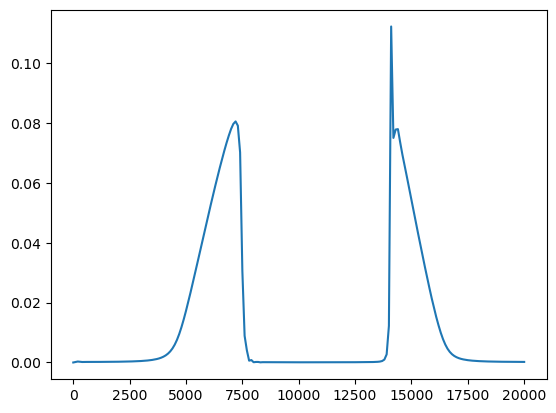

  5.792189 seconds (21.78 M allocations: 735.724 MiB, 4.66% gc time)


In [10]:
fixed = ParameterList(ω0 => 1.0,γ => 1E-2,  F => 1E-3,  α => 1.,  η=>0.3, θ => 0, ψ => 0)
prob = ODEProblem(averagedEOM, fixed,sweep=sweep_circle; x0=[0.0001;0.0001], timespan=(0, 2E4))
@time time_soln = solve(prob,saveat=100);
HarmonicBalance.plot(getindex.(time_soln.t, 1), getindex.(time_soln.u,1).^2 .+ getindex.(time_soln.u,2).^2);

# Use steady-state solutions as initial conditions

In [11]:
fixed_parameters = ParameterList(ω0 => 1.0,γ => 1E-2,  F => 1E-3,  α => 1.,  η=>0.3, θ => 0, ψ => 0, λ=>0.05)
params_range = ParameterRange(ω => LinRange(1.04,1.1,100))
ss_problem = Problem(averagedEOM)
steady_soln = get_steady_states(ss_problem, params_range, fixed_parameters)

Tracking 9 paths... 100%|███████████████████████████████| Time: 0:00:13
  # paths tracked:                  9
  # non-singular solutions (real):  5 (5)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         5 (5)


In [12]:
# select a solution and evolve from it
index = 75
s1 = get_single_solution(steady_soln, branch=1, index=1);
s2 = get_single_solution(steady_soln, branch=2, index=1);
s3 = get_single_solution(steady_soln, branch=3, index=1);

sweep = ParameterSweep(ω => (s1[ω], 1.1), (0, 1E4))
function t_solve(s)
    problem = ODEProblem(averagedEOM, steady_solution=s, timespan=(0,1E4), sweep=sweep)
    time_soln = solve(problem,saveat=10);
end

t_solve (generic function with 1 method)

In [13]:
# time-evolve all three solutions
time_soln_1 = t_solve(s1)
time_soln_2 = t_solve(s2)
time_soln_3 = t_solve(s3);

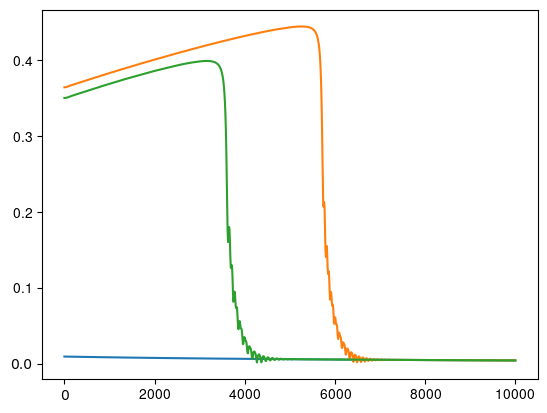

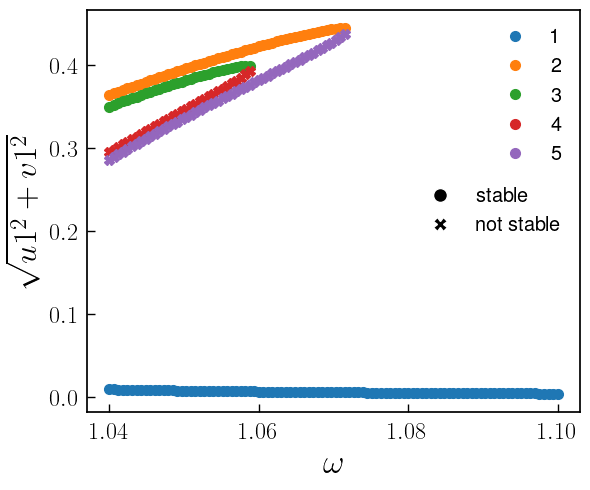

/usr/lib/python3/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [14]:
# contrast to steady-state solution
plot_td(s) = HarmonicBalance.plot(s.t, sqrt.(getindex.(s.u,1).^2 .+ getindex.(s.u,2).^2))
plot_td(time_soln_1)
plot_td(time_soln_2)
plot_td(time_soln_3)
HarmonicBalance.plot_1D_solutions(steady_soln, x="ω", y="sqrt(u1^2 + v1^2)")